In [2]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias
from exp_hp import get_hp
#from utils import detrend_members

2024-08-05 15:05:27.781657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


### Load standardized E3SM

In [4]:
EXP_NAME = 'exp1'
hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

_, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps['train_mems'],
                                                  valmem = hps['val_mems'][0],
                                                  testmem = hps['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps['LEAD'])

X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))

GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
files do not exist - loading data & saving


### Test NN

0


2024-08-05 15:05:50.274408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


235/235 [==============================] - 0s 1ms/step
1
235/235 [==============================] - 1s 2ms/step
2
235/235 [==============================] - 0s 807us/step
3
235/235 [==============================] - 1s 2ms/step
4
235/235 [==============================] - 0s 1ms/step
5
235/235 [==============================] - 0s 1ms/step
6
235/235 [==============================] - 0s 1ms/step
7
235/235 [==============================] - 1s 2ms/step
8
235/235 [==============================] - 1s 3ms/step
9
235/235 [==============================] - 1s 3ms/step


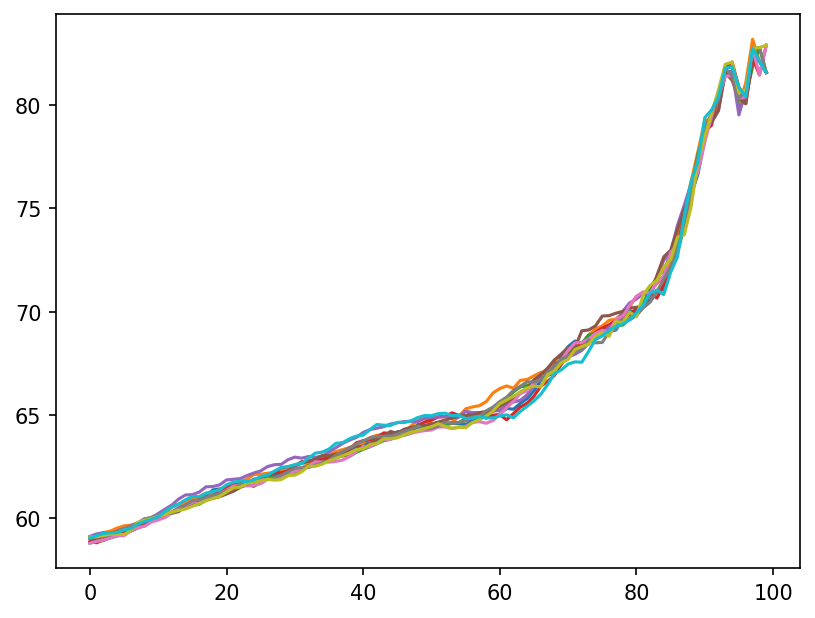

In [5]:
#----- SET UP & TRAIN NN -----
acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann_60Eshift_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)
    
    pred = ann.predict(X1test)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == Y1test[iconf])
        
        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    
    acc_all.append(acc)

np.save(base_dir+'test/confvsacc/confvsacc_ann1_60Eshift_'+EXP_NAME+'.npy', acc_all, allow_pickle=True)

### Accuracy of Network during ENSO:

In [7]:
# get SST data:
cvdp_path = '/glade/u/home/kjmayer/data/CESM2-LE/CVDP/'
ens      = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020']
ens_strt = ['1011','1031','1051','1071','1091','1111','1131','1151','1171','1191','1231','1231','1231','1231','1231','1231','1231','1231','1231','1231']

for e in range(len(ens)):
    cvdp_finame = 'CESM2-LENS_'+ens_strt[e]+'.'+ens[e]+'.cvdp_data.1850-2100.nc'
    if e == 0:
        nino34 = xr.open_dataset(cvdp_path+cvdp_finame,decode_times=False)['nino34']
    elif e > 0:
        temp_nino34 = xr.open_dataset(cvdp_path+cvdp_finame,decode_times=False)['nino34']
        nino34 = xr.concat([nino34,temp_nino34],dim='ens')

newtime = pd.date_range("1850-01-01", freq="MS", periods=len(nino34.time))
nino34['time'] = newtime                           
nino34 = nino34.where((nino34.time.dt.year >= 1950) & (nino34.time.dt.year <= 2015), drop = True)

nino34_ensmean = nino34.mean('ens')

nino34_detrended = detrend_members(data = nino34, 
                                   ensmean_data = nino34_ensmean, 
                                   npoly=3)

nino34_detrended_upsample = nino34_detrended.resample(time='1D').asfreq()
nino34_detrended_upsample = nino34_detrended_upsample.where(~((nino34_detrended_upsample.time.dt.month == 2) & (nino34_detrended_upsample.time.dt.day == 29)),drop=True)
nino34_detrended_upsample = nino34_detrended_upsample.ffill(dim='time')
nino34_detrended_upsample = nino34_detrended_upsample[:,6:-335] # 6: account for days 1-6 missing in X because of rolling mean; 
                                                                #-355: had to go through 2015 (not 2014) to get all days in Dec 2014 (not just 12-01-2014)

# nino34_detrended[0].plot()
# nino34_detrended_upsample[0].plot()

nino34_test = nino34_detrended_upsample[hps['test_mems'][0]-1,:-6][:-hps['LEAD']]
nino34_test_NDJF = nino34_test[nino34_test.time.dt.month.isin([11,12,1,2])]
nino34test = nino34_test_NDJF.isel(time = inew,drop=True)

0
235/235 [==============================] - 0s 1ms/step
1
235/235 [==============================] - 0s 1ms/step
2
235/235 [==============================] - 0s 1ms/step
3
235/235 [==============================] - 0s 1ms/step
4
235/235 [==============================] - 0s 1ms/step
5
235/235 [==============================] - 0s 1ms/step
6
235/235 [==============================] - 0s 1ms/step
7
235/235 [==============================] - 0s 1ms/step
8
235/235 [==============================] - 0s 1ms/step
9
235/235 [==============================] - 0s 1ms/step


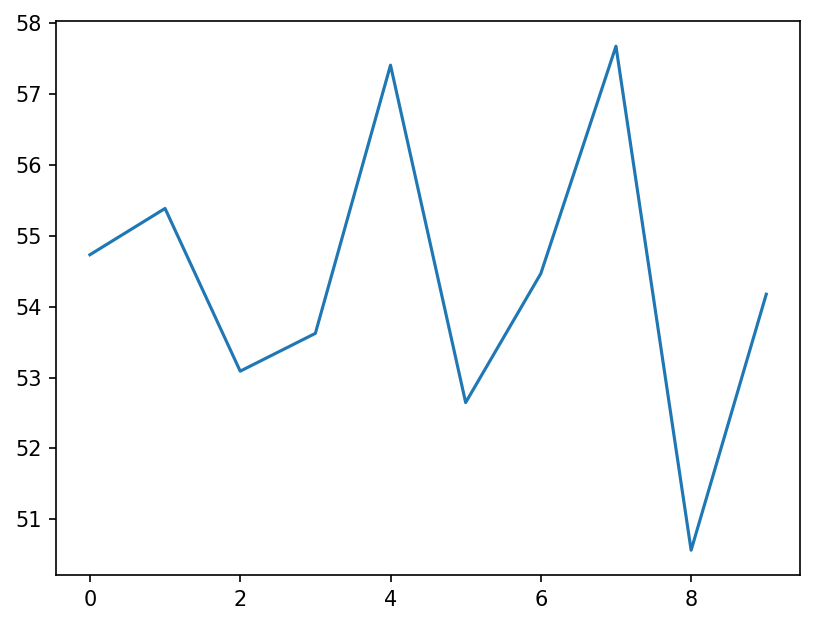

In [45]:

acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann_60Ebias_'+EXP_NAME+'_seed'+str(SEED)+'.h5' 
    ann = tf.keras.models.load_model(base_dir+'models/'+annfi_name)
    
    iENSO = (nino34test > 1) | (nino34test < -1)
    pred = ann.predict(X1test)
    
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)
    q = 80
    iconf = predconf >= np.percentile(predconf,q=q)
    
    iconfENSO = iconf & iENSO
    
    iconfcorrENSO = predval[iconfENSO] == Y1test[iconfENSO]
    
    # percent of predictions correct when the network is confident during an ENSO event
    acc_all.append((np.shape(np.where(iconfcorrENSO)[0])[0]/np.shape(np.where(iconfENSO)[0])[0])*100)
plt.plot(acc_all)



In [36]:
q = 80

iENSO = (nino34test > 1) | (nino34test < -1)

pred = ann.predict(X1test)
predconf = np.max(pred,axis=-1)
iconf = predconf >= np.percentile(predconf,q=q)

# fraction of confident predictions during ENSO:
iconfENSO = iENSO & iconf

print(np.shape(pred[iconfENSO])[0]/np.shape(pred[iconf])[0])

# fraction of ENSO days
print(np.shape(pred[iENSO])[0]/np.shape(pred)[0])

235/235 [==============================] - 0s 1ms/step
0.6390927284856571
0.6590605817987724


In [42]:
np.shape(np.where(iconf)[0])[0]

(1499,)